In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
from pathlib import Path

BASE_DIR = Path("/content/drive/Shareddrives/TissueMotionForecasting")
DATA_ROOT = BASE_DIR / "scared_pipeline" / "preprocessed" / "dataset_2" / "keyframe_1" / "data"

LEFT_DIR = DATA_ROOT / "left_rectified"
RIGHT_DIR = DATA_ROOT / "right_rectified"

print("Base Directory:", BASE_DIR)
print("Left Path:", LEFT_DIR)
print("Right Path:", RIGHT_DIR)
print("Left Exists:", LEFT_DIR.exists())
print("Right Exists:", RIGHT_DIR.exists())


Base Directory: /content/drive/Shareddrives/TissueMotionForecasting
Left Path: /content/drive/Shareddrives/TissueMotionForecasting/scared_pipeline/preprocessed/dataset_2/keyframe_1/data/left_rectified
Right Path: /content/drive/Shareddrives/TissueMotionForecasting/scared_pipeline/preprocessed/dataset_2/keyframe_1/data/right_rectified
Left Exists: True
Right Exists: True


In [ ]:
!git clone https://github.com/princeton-vl/RAFT-Stereo.git /content/raft-stereo
%cd /content/raft-stereo
!pip install -r requirements.txt


In [ ]:
%cd /content/raft-stereo
!bash download_models.sh



/content/raft-stereo
--2025-11-29 20:15:17--  https://www.dropbox.com/s/ftveifyqcomiwaq/models.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/z720aslw752iypqqdre7c/models.zip?rlkey=3criskutu26wwrx4h9g42aqx0 [following]
--2025-11-29 20:15:17--  https://www.dropbox.com/scl/fi/z720aslw752iypqqdre7c/models.zip?rlkey=3criskutu26wwrx4h9g42aqx0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc1af9d26bf31a88657ca385243.dl.dropboxusercontent.com/cd/0/inline/C2EZXeavzXKmaaXlfOEdy0N1xwZ70O5xOK9MzfM3L7WZ4XaU5whI8RhuDT9n3mEVGng8MEFQ_onEiLCxqhGQ53rYX5VMvsizrabLydbNXYLdz-2U8EihVym08jcZhmj69MKxWYnRkIXNHKS_YMkkMey0/file# [following]
--2025-11-29 20:15:17--  https://ucc1af9d26bf31a88657ca385243.dl.dropboxusercontent

In [ ]:
%cd /content/raft-stereo

import sys
import torch
from argparse import Namespace

sys.path.append('core')
from raft_stereo import RAFTStereo
from utils.utils import InputPadder


args = Namespace(
    restore_ckpt=None,
    dataset="eth3d",
    mixed_precision=False,
    valid_iters=32,

    hidden_dims=[128, 128, 128],
    corr_implementation="reg",
    shared_backbone=False,
    corr_levels=4,
    corr_radius=4,
    n_downsample=2,
    context_norm="batch",
    slow_fast_gru=False,
    n_gru_layers=3,
)

WEIGHT_PATH = "/content/raft-stereo/models/raftstereo-sceneflow.pth"


state = torch.load(WEIGHT_PATH, map_location="cuda", weights_only=False)


if isinstance(state, dict) and "state_dict" in state:
    state = state["state_dict"]

model = RAFTStereo(args)
model.load_state_dict(state, strict=False)
model = model.cuda().eval()

print("RAFT-Stereo loaded successfully!")


In [ ]:
!pip install tifffile pyyaml


In [ ]:
import cv2
import numpy as np

def load_calibration_opencv(path):
    fs = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)

    # Intrinsics
    M1 = fs.getNode("M1").mat()
    fx = M1[0,0]
    fy = M1[1,1]
    cx = M1[0,2]
    cy = M1[1,2]

    # Translation
    T = fs.getNode("T").mat().reshape(-1)
    baseline_mm = abs(T[0])

    fs.release()
    return fx, fy, cx, cy, baseline_mm




In [ ]:
fx, fy, cx, cy, baseline = load_calibration_opencv(
    "/content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2/keyframe_1/endoscope_calibration.yaml"
)

print("fx =", fx)
print("fy =", fy)
print("cx =", cx)
print("cy =", cy)
print("baseline (mm) =", baseline)

fx = 1035.3081
fy = 1035.0876
cx = 596.955
cy = 520.41003
baseline (mm) = 4.14339


In [ ]:
import numpy as np
import cv2
import tifffile as tiff
import matplotlib.pyplot as plt
from pathlib import Path

def load_calibration_opencv(path):
    fs = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)

    M1 = fs.getNode("M1").mat()
    T  = fs.getNode("T").mat()

    fx = float(M1[0,0])
    fy = float(M1[1,1])
    cx = float(M1[0,2])
    cy = float(M1[1,2])

    T = T.reshape(-1)
    baseline_mm = abs(float(T[0]))

    fs.release()
    return fx, fy, cx, cy, baseline_mm


def depth_to_disparity(depth_mm, fx, baseline_mm):
    depth = depth_mm.astype(np.float32)
    depth[depth <= 0] = np.nan
    disp = fx * baseline_mm / depth
    disp[~np.isfinite(disp)] = 0
    return disp


KF_ROOT = Path("/content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2")
OUT_ROOT = Path("/content/drive/Shareddrives/TissueMotionForecasting/disparity_gt/dataset_2")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

for k in range(1, 6):
    print(f"\nProcessing keyframe_{k} ...")
    kf_dir = KF_ROOT / f"keyframe_{k}"

    calib_path = kf_dir / "endoscope_calibration.yaml"
    left_depth_path = kf_dir / "left_depth_map.tiff"
    right_depth_path = kf_dir / "right_depth_map.tiff"
    imgL_path = kf_dir / "Left_Image.png"
    imgR_path = kf_dir / "Right_Image.png"

    fx, fy, cx, cy, baseline_mm = load_calibration_opencv(calib_path)

    # load left depth
    depthL = tiff.imread(str(left_depth_path))
    dispL = depth_to_disparity(depthL, fx, baseline_mm)

    # load right depth
    if right_depth_path.exists():
        depthR = tiff.imread(str(right_depth_path))
        dispR = depth_to_disparity(depthR, fx, baseline_mm)
    else:
        dispR = None

    out_kf = OUT_ROOT / f"keyframe_{k}"
    out_kf.mkdir(parents=True, exist_ok=True)

    # save raw disparity
    np.save(out_kf / "left_disparity.npy", dispL)
    if dispR is not None:
        np.save(out_kf / "right_disparity.npy", dispR)

    # visualization
    imgL = cv2.cvtColor(cv2.imread(str(imgL_path)), cv2.COLOR_BGR2RGB)
    imgR = cv2.cvtColor(cv2.imread(str(imgR_path)), cv2.COLOR_BGR2RGB)

    valid = dispL > 0
    vmin, vmax = np.percentile(dispL[valid], [3, 97])

    plt.figure(figsize=(16,5))

    plt.subplot(1,3,1)
    plt.imshow(imgL)
    plt.title("Left Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(imgR)
    plt.title("Right Image")
    plt.axis("off")

    plt.subplot(1,3,3)
    im = plt.imshow(dispL, cmap="jet", vmin=vmin, vmax=vmax)
    plt.title("GT Disparity (Left)")
    plt.colorbar(im, fraction=0.046)
    plt.axis("off")

    plt.savefig(out_kf / "left_right_disparity_gt.png", dpi=200, bbox_inches="tight")
    plt.close()

    print(f"Saved left_disparity.npy and visualization to {out_kf}")



Processing keyframe_1 ...


  ✓ Saved left_disparity.npy and visualization to /content/drive/Shareddrives/TissueMotionForecasting/disparity_gt/dataset_2/keyframe_1

Processing keyframe_2 ...


  ✓ Saved left_disparity.npy and visualization to /content/drive/Shareddrives/TissueMotionForecasting/disparity_gt/dataset_2/keyframe_2

Processing keyframe_3 ...


  ✓ Saved left_disparity.npy and visualization to /content/drive/Shareddrives/TissueMotionForecasting/disparity_gt/dataset_2/keyframe_3

Processing keyframe_4 ...


  ✓ Saved left_disparity.npy and visualization to /content/drive/Shareddrives/TissueMotionForecasting/disparity_gt/dataset_2/keyframe_4

Processing keyframe_5 ...


  ✓ Saved left_disparity.npy and visualization to /content/drive/Shareddrives/TissueMotionForecasting/disparity_gt/dataset_2/keyframe_5


In [ ]:
import tifffile as tiff
import numpy as np

path = "/content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2/keyframe_1/left_depth_map.tiff"

depth = tiff.imread(path)

print("Shape:", depth.shape)
print("Dtype:", depth.dtype)
print("Unique values (sample):", np.unique(depth[:100,:100])[:20])
print("Min:", np.min(depth), " Max:", np.max(depth))


Shape: (1024, 1280, 3)
Dtype: float32
Unique values (sample): [-34.080406 -34.077534 -34.074856 -33.78772  -33.784817 -33.782627
 -33.78253  -33.77887  -33.725777 -33.674725 -33.671734 -33.66893
 -33.666317 -33.56139  -33.55841  -33.555614 -33.553013 -33.498867
 -33.49882  -33.498398]
Min: nan  Max: nan


Z min/max: -308.8844 467.86575
Abs(Z) min/max: 20.700453 467.86575


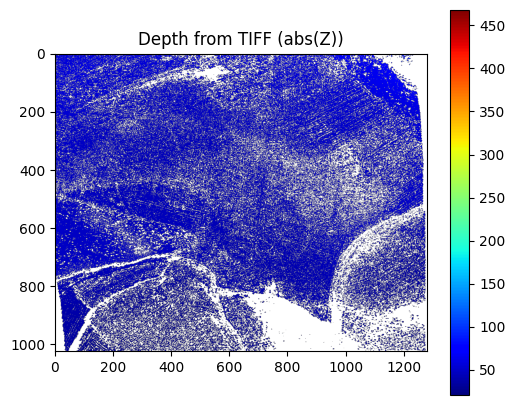

In [ ]:
depth = tiff.imread(path).astype(np.float32)

X = depth[:,:,0]
Y = depth[:,:,1]
Z = depth[:,:,2]

print("Z min/max:", np.nanmin(Z), np.nanmax(Z))
print("Abs(Z) min/max:", np.nanmin(abs(Z)), np.nanmax(abs(Z)))

plt.figure(figsize=(6,5))
plt.imshow(abs(Z), cmap="jet")
plt.colorbar()
plt.title("Depth from TIFF (abs(Z))")
plt.show()


In [ ]:
import numpy as np
import cv2
import tifffile as tiff
from pathlib import Path
import matplotlib.pyplot as plt

def load_calibration_opencv(path):
    fs = cv2.FileStorage(str(path), cv2.FILE_STORAGE_READ)
    M1 = fs.getNode("M1").mat()
    T  = fs.getNode("T").mat()
    fs.release()

    fx = float(M1[0,0])
    fy = float(M1[1,1])
    cx = float(M1[0,2])
    cy = float(M1[1,2])

    T  = T.reshape(-1)
    baseline_mm = abs(float(T[0]))
    return fx, fy, cx, cy, baseline_mm


def load_point_cloud_obj(obj_path):
    pts = []
    with open(obj_path, 'r') as f:
        for line in f:
            if line.startswith('v '):
                _, x, y, z = line.strip().split()[:4]
                pts.append([float(x), float(y), float(z)])
    return np.array(pts, dtype=np.float32)


def pointcloud_to_depth(points, fx, fy, cx, cy, H, W):
    depth = np.full((H, W), np.nan, dtype=np.float32)

    X = points[:, 0]
    Y = points[:, 1]
    Z = points[:, 2]

    valid = Z > 0
    X, Y, Z = X[valid], Y[valid], Z[valid]

    u = (fx * X / Z + cx).astype(int)
    v = (fy * Y / Z + cy).astype(int)

    inside = (u >= 0) & (u < W) & (v >= 0) & (v < H)
    u, v, Z = u[inside], v[inside], Z[inside]

    for ui, vi, zi in zip(u, v, Z):
        old = depth[vi, ui]
        if np.isnan(old) or zi < old:
            depth[vi, ui] = zi

    return depth

def inpaint_depth(depth):
    depth_in = depth.copy()
    mask = np.isnan(depth_in)
    depth_in[mask] = 0.0
    mask_u8 = (mask.astype(np.uint8) * 255)

    depth_filled = cv2.inpaint(depth_in.astype(np.float32),
                               mask_u8,
                               5,
                               cv2.INPAINT_TELEA)
    return depth_filled


In [ ]:
KF = 1

root_kf = Path("/content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2") / f"keyframe_{KF}"
calib_path = root_kf / "endoscope_calibration.yaml"
obj_path   = root_kf / "point_cloud.obj"
imgL_path  = root_kf / "Left_Image.png"

# Load calibration
fx, fy, cx, cy, baseline_mm = load_calibration_opencv(calib_path)

# Load left image to get size
imgL = cv2.cvtColor(cv2.imread(str(imgL_path)), cv2.COLOR_BGR2RGB)
H, W = imgL.shape[:2]

# Load point cloud
points = load_point_cloud_obj(obj_path)
print("Loaded points:", points.shape)

# Project to depth
depth_sparse = pointcloud_to_depth(points, fx, fy, cx, cy, H, W)
depth_dense  = inpaint_depth(depth_sparse)

# Compute disparity from dense depth (depth in mm, baseline in mm)
depth_dense[depth_dense <= 0] = np.nan
disp = fx * baseline_mm / depth_dense
disp[~np.isfinite(disp)] = 0.0


Loaded points: (1310720, 3)


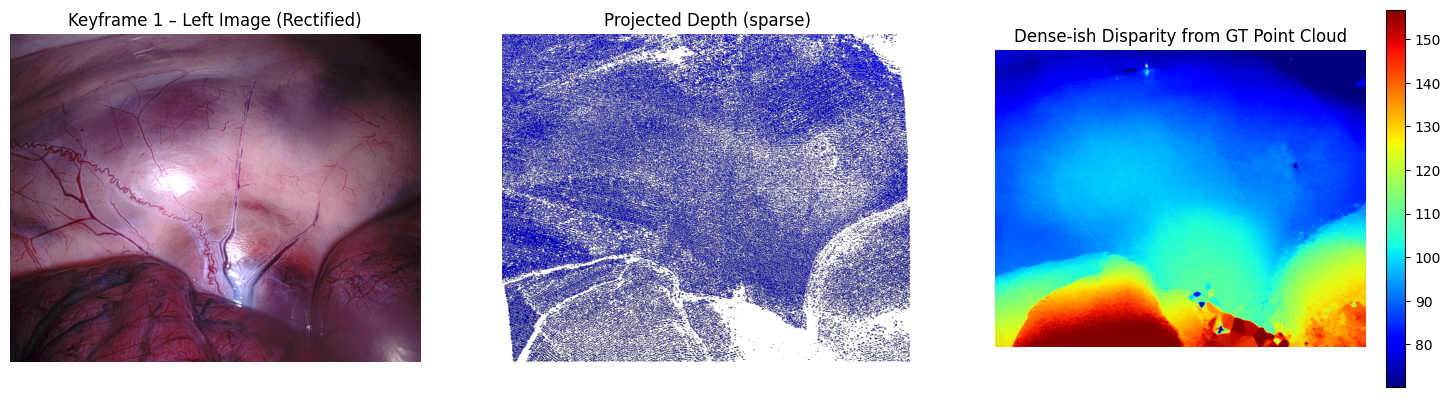

In [ ]:
valid = disp > 0
vmin, vmax = np.percentile(disp[valid], [3, 97])

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.imshow(imgL)
plt.title(f"Keyframe {KF} – Left Image (Rectified)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(depth_sparse, cmap="jet")
plt.title("Projected Depth (sparse)")
plt.axis("off")

plt.subplot(1,3,3)
im = plt.imshow(disp, cmap="jet", vmin=vmin, vmax=vmax)
plt.title("Dense-ish Disparity from GT Point Cloud")
plt.colorbar(im, fraction=0.046)
plt.axis("off")

plt.show()


Found keyframes: ['keyframe_1', 'keyframe_2', 'keyframe_3', 'keyframe_4', 'keyframe_5']

Processing keyframe_1 ...
  Loaded points: (1310720, 3)


KeyboardInterrupt: 

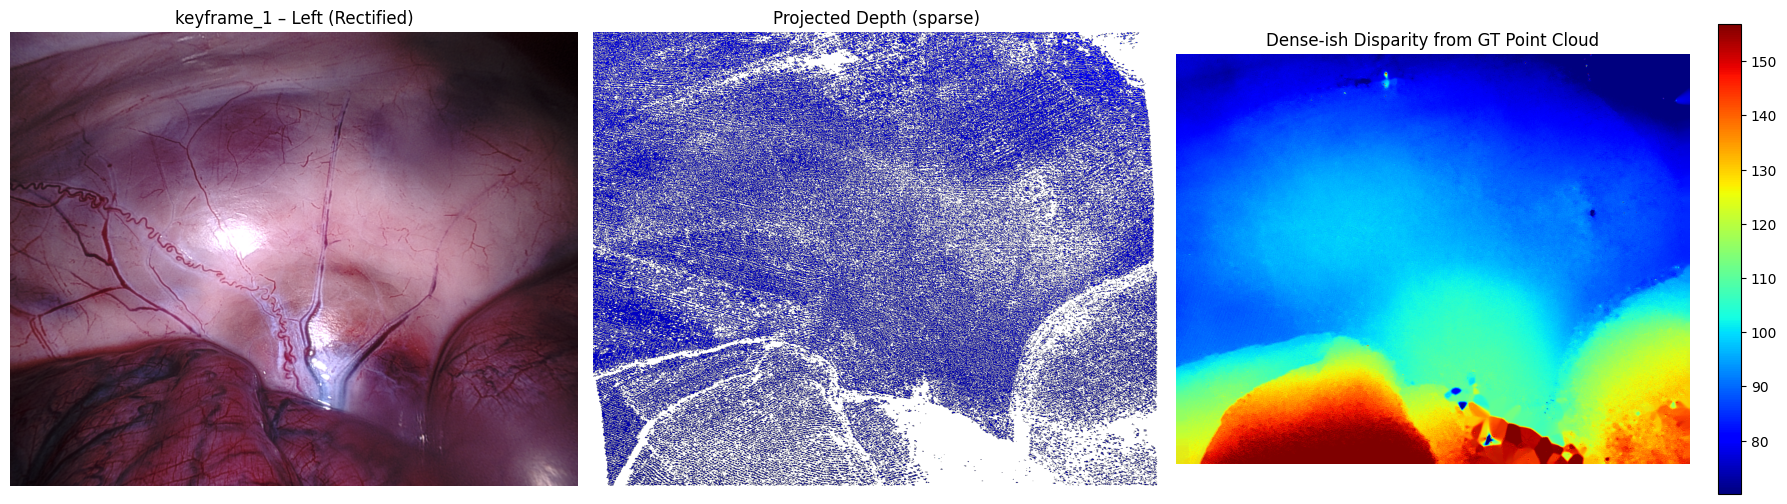

In [ ]:
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

def load_calibration_opencv(path):
    fs = cv2.FileStorage(str(path), cv2.FILE_STORAGE_READ)
    M1 = fs.getNode("M1").mat()
    T  = fs.getNode("T").mat()
    fs.release()

    fx = float(M1[0,0])
    fy = float(M1[1,1])
    cx = float(M1[0,2])
    cy = float(M1[1,2])

    T  = T.reshape(-1)
    baseline_mm = abs(float(T[0]))
    return fx, fy, cx, cy, baseline_mm

def load_point_cloud_obj(obj_path):
    pts = []
    with open(obj_path, 'r') as f:
        for line in f:
            if line.startswith('v '):
                _, x, y, z = line.strip().split()[:4]
                pts.append([float(x), float(y), float(z)])
    return np.array(pts, dtype=np.float32)


def pointcloud_to_depth(points, fx, fy, cx, cy, H, W):
    depth = np.full((H, W), np.nan, dtype=np.float32)

    X = points[:, 0]
    Y = points[:, 1]
    Z = points[:, 2]

    valid = Z > 0
    X, Y, Z = X[valid], Y[valid], Z[valid]

    u = (fx * X / Z + cx).astype(int)
    v = (fy * Y / Z + cy).astype(int)

    inside = (u >= 0) & (u < W) & (v >= 0) & (v < H)
    u, v, Z = u[inside], v[inside], Z[inside]

    for ui, vi, zi in zip(u, v, Z):
        old = depth[vi, ui]
        if np.isnan(old) or zi < old:
            depth[vi, ui] = zi

    return depth

def inpaint_depth(depth):
    depth_in = depth.copy()
    mask = np.isnan(depth_in)
    depth_in[mask] = 0.0
    mask_u8 = (mask.astype(np.uint8) * 255)

    depth_filled = cv2.inpaint(depth_in.astype(np.float32),
                               mask_u8,
                               5,
                               cv2.INPAINT_TELEA)
    return depth_filled


ROOT = Path("/content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2")

keyframes = sorted([d for d in ROOT.iterdir() if d.is_dir() and d.name.startswith("keyframe_")])
print("Found keyframes:", [kf.name for kf in keyframes])

for kf in keyframes:
    print(f"\nProcessing {kf.name} ...")

    calib_path = kf / "endoscope_calibration.yaml"
    obj_path   = kf / "point_cloud.obj"
    imgL_path  = kf / "Left_Image.png"

    if not (calib_path.exists() and obj_path.exists() and imgL_path.exists()):
        print("  Missing files, skipping.")
        continue

    fx, fy, cx, cy, baseline_mm = load_calibration_opencv(calib_path)

    imgL = cv2.cvtColor(cv2.imread(str(imgL_path)), cv2.COLOR_BGR2RGB)
    H, W = imgL.shape[:2]

    points = load_point_cloud_obj(obj_path)
    print("  Loaded points:", points.shape)
    depth_sparse = pointcloud_to_depth(points, fx, fy, cx, cy, H, W)

    depth_dense = inpaint_depth(depth_sparse)


    depth_dense[depth_dense <= 0] = np.nan
    disp = fx * baseline_mm / depth_dense
    disp[~np.isfinite(disp)] = 0.0

    valid = disp > 0
    if valid.any():
        vmin, vmax = np.percentile(disp[valid], [3, 97])
    else:
        vmin, vmax = 0, 1


    OUT = kf / "outputs_gt"
    OUT.mkdir(exist_ok=True)


    np.save(OUT / "depth_sparse_mm.npy", depth_sparse)
    np.save(OUT / "depth_dense_mm.npy", depth_dense)
    np.save(OUT / "disp_gt.npy", disp)


    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(imgL)
    plt.title(f"{kf.name} – Left (Rectified)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(depth_sparse, cmap="jet")
    plt.title("Projected Depth (sparse)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    im = plt.imshow(disp, cmap="jet", vmin=vmin, vmax=vmax)
    plt.title("Dense-ish Disparity from GT Point Cloud")
    plt.colorbar(im, fraction=0.046)
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(OUT / "triple_panel_gt.png", dpi=200)
    plt.close()

    print("  Saved outputs in:", OUT)

print("\nALL KEYFRAMES DONE.")



In [ ]:
import cv2
import matplotlib.pyplot as plt

video_path = "/content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2/keyframe_1/data/rgb.mp4"
cap = cv2.VideoCapture(video_path)

ret, frame = cap.read()
cap.release()

print("Frame shape:", frame.shape)

plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("First Frame of rgb.mp4")
plt.axis("off")


In [ ]:
import cv2
import os
from pathlib import Path

ROOT = Path("/content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2")


keyframes = sorted([kf for kf in ROOT.iterdir() if kf.is_dir()])
print("Found keyframes:", keyframes)

for kf in keyframes:
    print("\n────────────────────────────────────────")
    print(f"Processing {kf.name} ...")

    video_path = kf / "data" / "rgb.mp4"
    if not video_path.exists():
        print("rgb.mp4 missing, skipping...")
        continue

    # Output directories for this keyframe
    OUT = kf / "video_frames"
    left_dir = OUT / "left"
    right_dir = OUT / "right"

    left_dir.mkdir(parents=True, exist_ok=True)
    right_dir.mkdir(parents=True, exist_ok=True)

    # Open the video
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print("ERROR: Cannot open", video_path)
        continue

    frame_idx = 0
    saved_idx = 0

    print(f"Extracting every 5th frame from {video_path.name}")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Process every 5th frame
        if frame_idx % 5 == 0:
            H = frame.shape[0] // 2  # split at the middle vertically

            left_frame  = frame[:H, :, :]
            right_frame = frame[H:, :, :]

            left_path  = left_dir / f"{saved_idx:06d}.png"
            right_path = right_dir / f"{saved_idx:06d}.png"

            cv2.imwrite(str(left_path), left_frame)
            cv2.imwrite(str(right_path), right_frame)

            print(f"Saved {kf.name}: {left_path.name}, {right_path.name}")
            saved_idx += 1

        frame_idx += 1

    cap.release()
    print(f"DONE: {kf.name} — saved {saved_idx} frames")

print("\COMPLETED EXTRACTION FOR ALL KEYFRAMES!")


In [ ]:
import os

base_kf = "/content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2/keyframe_1"
data_dir = f"{base_kf}/data"
extract_dir = f"{base_kf}/extracted_scene"

os.makedirs(extract_dir, exist_ok=True)


In [ ]:
depth_dir = f"{extract_dir}/depth_tiff"
frame_data_dir = f"{extract_dir}/frame_meta"

os.makedirs(depth_dir, exist_ok=True)
os.makedirs(frame_data_dir, exist_ok=True)

print("Depth TIFF folder:", depth_dir)
print("Frame metadata folder:", frame_data_dir)


Depth TIFF folder: /content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2/keyframe_1/extracted_scene/depth_tiff
Frame metadata folder: /content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2/keyframe_1/extracted_scene/frame_meta


In [ ]:
!tar -xvf "{data_dir}/scene_points.tar.gz" -C "{depth_dir}"


scene_points000000.tiff
scene_points000001.tiff
scene_points000002.tiff
scene_points000003.tiff
scene_points000004.tiff
scene_points000005.tiff
scene_points000006.tiff
scene_points000007.tiff
scene_points000008.tiff
scene_points000009.tiff
scene_points000010.tiff
scene_points000011.tiff
scene_points000012.tiff
scene_points000013.tiff
scene_points000014.tiff
scene_points000015.tiff
scene_points000016.tiff
scene_points000017.tiff
scene_points000018.tiff
scene_points000019.tiff
scene_points000020.tiff
scene_points000021.tiff
scene_points000022.tiff
scene_points000023.tiff
scene_points000024.tiff
scene_points000025.tiff
scene_points000026.tiff
scene_points000027.tiff
scene_points000028.tiff
scene_points000029.tiff
scene_points000030.tiff
scene_points000031.tiff
scene_points000032.tiff
scene_points000033.tiff
scene_points000034.tiff
scene_points000035.tiff
scene_points000036.tiff
scene_points000037.tiff
scene_points000038.tiff
scene_points000039.tiff
scene_points000040.tiff
scene_points0000

In [ ]:
!tar -xvf "{data_dir}/frame_data.tar.gz" -C "{frame_data_dir}"


frame_data000000.json
frame_data000001.json
frame_data000002.json
frame_data000003.json
frame_data000004.json
frame_data000005.json
frame_data000006.json
frame_data000007.json
frame_data000008.json
frame_data000009.json
frame_data000010.json
frame_data000011.json
frame_data000012.json
frame_data000013.json
frame_data000014.json
frame_data000015.json
frame_data000016.json
frame_data000017.json
frame_data000018.json
frame_data000019.json
frame_data000020.json
frame_data000021.json
frame_data000022.json
frame_data000023.json
frame_data000024.json
frame_data000025.json
frame_data000026.json
frame_data000027.json
frame_data000028.json
frame_data000029.json
frame_data000030.json
frame_data000031.json
frame_data000032.json
frame_data000033.json
frame_data000034.json
frame_data000035.json
frame_data000036.json
frame_data000037.json
frame_data000038.json
frame_data000039.json
frame_data000040.json
frame_data000041.json
frame_data000042.json
frame_data000043.json
frame_data000044.json
frame_data

In [ ]:
kf = "keyframe_1"
root = "/content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2"
kf_dir = f"{root}/{kf}"

left_dir  = f"{kf_dir}/video_frames/left"
right_dir = f"{kf_dir}/video_frames/right"

out_disp  = f"{kf_dir}/raft_video_pred/disp"
out_depth = f"{kf_dir}/raft_video_pred/depth_mm"

os.makedirs(out_disp, exist_ok=True)
os.makedirs(out_depth, exist_ok=True)

left_frames = sorted([f for f in os.listdir(left_dir) if f.endswith(".png")])
print("Found", len(left_frames), "stereo video-frame pairs")


Found 18 stereo video-frame pairs


In [ ]:
import numpy as np
import cv2
import tifffile as tiff
from pathlib import Path
import matplotlib.pyplot as plt


def load_calibration_opencv(path):
    fs = cv2.FileStorage(str(path), cv2.FILE_STORAGE_READ)

    M1 = fs.getNode("M1").mat()
    T  = fs.getNode("T").mat()

    fs.release()

    fx = float(M1[0,0])

    T = T.reshape(-1)
    baseline_mm = abs(float(T[0]))

    return fx, baseline_mm



KF = 1
ROOT = Path("/content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2")
kf_dir = ROOT / f"keyframe_{KF}"

calib_path      = kf_dir / "endoscope_calibration.yaml"
depth_tiff_dir  = kf_dir / "extracted_scene" / "depth_tiff"
video_left_dir  = kf_dir / "video_frames" / "left"
out_dir         = kf_dir / "video_frames" / "gt_disparity"
out_dir.mkdir(exist_ok=True)


fx, baseline_mm = load_calibration_opencv(calib_path)
print("fx =", fx, " baseline =", baseline_mm)


extracted_images = sorted(video_left_dir.glob("*.png"))
print("Found extracted frames:", len(extracted_images))


for img_path in extracted_images:

    extracted_idx = int(img_path.stem)
    orig_idx = extracted_idx * 5

    tiff_path = depth_tiff_dir / f"scene_points{orig_idx:06d}.tiff"
    print("Mapping:", img_path.name, "->", tiff_path.name)

    if not tiff_path.exists():
        print("Missing TIFF:", tiff_path)
        continue

    depth_xyz = tiff.imread(str(tiff_path)).astype(np.float32)
    Z = depth_xyz[:, :, 2]

    Z[Z <= 0] = np.nan

    # Compute disparity from GT depth
    disp = fx * baseline_mm / Z
    disp[~np.isfinite(disp)] = 0


    np.save(out_dir / f"disp_{extracted_idx:06d}.npy", disp)

    valid = disp > 0
    vmin, vmax = np.percentile(disp[valid], [3, 97])

    plt.figure(figsize=(6,5))
    im = plt.imshow(disp, cmap="jet", vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title(f"GT Disparity {extracted_idx:06d}")
    plt.axis("off")
    plt.savefig(out_dir / f"disp_{extracted_idx:06d}.png", dpi=200)
    plt.close()

    print("✓ Saved", extracted_idx)

print("\nDONE — All 18 GT disparity maps created!")


In [ ]:
import numpy as np
import cv2
import tifffile as tiff
from pathlib import Path
import matplotlib.pyplot as plt


def load_calibration_opencv(path):
    fs = cv2.FileStorage(str(path), cv2.FILE_STORAGE_READ)

    M1 = fs.getNode("M1").mat()
    T  = fs.getNode("T").mat()
    fs.release()

    fx = float(M1[0,0])

    T = T.reshape(-1)
    baseline_mm = abs(float(T[0]))

    return fx, baseline_mm


KF = 1
ROOT = Path("/content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2")
kf_dir = ROOT / f"keyframe_{KF}"

calib_path      = kf_dir / "endoscope_calibration.yaml"
depth_tiff_dir  = kf_dir / "extracted_scene" / "depth_tiff"
video_left_dir  = kf_dir / "video_frames" / "left"
out_dir         = kf_dir / "video_frames" / "gt_disparity"
out_dir.mkdir(exist_ok=True)


fx, baseline_mm = load_calibration_opencv(calib_path)
print("fx =", fx, " baseline =", baseline_mm, "mm")


extracted_images = sorted(video_left_dir.glob("*.png"))
print("Found extracted frames:", len(extracted_images))

for img_path in extracted_images:

    extracted_idx = int(img_path.stem)
    orig_idx = extracted_idx * 5
    tiff_path = depth_tiff_dir / f"scene_points{orig_idx:06d}.tiff"
    print("Mapping:", img_path.name, "->", tiff_path.name)

    if not tiff_path.exists():
        print(" Missing TIFF:", tiff_path)
        continue


    depth_xyz = tiff.imread(str(tiff_path)).astype(np.float32)

    H = depth_xyz.shape[0] // 2
    depth_xyz = depth_xyz[:H, :, :]

    Z = depth_xyz[:, :, 2]
    Z[Z <= 0] = np.nan


    disp = fx * baseline_mm / Z
    disp[~np.isfinite(disp)] = 0

    np.save(out_dir / f"disp_{extracted_idx:06d}.npy", disp)

    valid = disp > 0
    if valid.any():
        vmin, vmax = np.percentile(disp[valid], [3, 97])
    else:
        vmin, vmax = 0, 1

    plt.figure(figsize=(6, 5))
    im = plt.imshow(disp, cmap="jet", vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title(f"GT Disparity {extracted_idx:06d}")
    plt.axis("off")
    plt.savefig(out_dir / f"disp_{extracted_idx:06d}.png", dpi=200)
    plt.close()

    print("✓ Saved", extracted_idx)

print("\nDONE — All 18 GT disparity maps created!")



In [ ]:
import os
import cv2
import numpy as np
import tifffile as tiff
from pathlib import Path
import matplotlib.pyplot as plt

def load_calibration_opencv(path):
    fs = cv2.FileStorage(str(path), cv2.FILE_STORAGE_READ)
    M1 = fs.getNode("M1").mat()
    T  = fs.getNode("T").mat()
    fs.release()

    fx = float(M1[0,0])
    T = T.reshape(-1)
    baseline_mm = abs(float(T[0]))
    return fx, baseline_mm



ROOT = Path("/content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2")
KEYFRAMES_TO_PROCESS = ["keyframe_2", "keyframe_3", "keyframe_4", "keyframe_5"]

print("Processing:", KEYFRAMES_TO_PROCESS)
for KF in KEYFRAMES_TO_PROCESS:

    print(f"\n\n==============================")
    print(f"Processing {KF} ...")
    print("==============================")

    kf_dir = ROOT / KF

    scene_tar = kf_dir / "data" / "scene_points.tar.gz"
    depth_tiff_dir = kf_dir / "extracted_scene" / "depth_tiff"
    depth_tiff_dir.mkdir(parents=True, exist_ok=True)

    print("Extracting scene_points...")
    os.system(f"tar -xvf '{scene_tar}' -C '{depth_tiff_dir}'")


    frame_tar = kf_dir / "data" / "frame_data.tar.gz"
    frame_data_dir = kf_dir / "extracted_scene" / "frame_meta"
    frame_data_dir.mkdir(parents=True, exist_ok=True)

    print("Extracting frame_data...")
    os.system(f"tar -xvf '{frame_tar}' -C '{frame_data_dir}'")


    rgb_path = kf_dir / "data" / "rgb.mp4"
    left_dir = kf_dir / "video_frames" / "left"
    right_dir = kf_dir / "video_frames" / "right"
    left_dir.mkdir(parents=True, exist_ok=True)
    right_dir.mkdir(parents=True, exist_ok=True)

    print("Extracting frames from rgb.mp4...")

    cap = cv2.VideoCapture(str(rgb_path))
    if not cap.isOpened():
        print("Could not open video:", rgb_path)
        continue

    frame_idx = 0
    saved_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % 5 == 0:
            H = frame.shape[0] // 2
            left_frame = frame[:H, :, :]
            right_frame = frame[H:, :, :]

            cv2.imwrite(str(left_dir / f"{saved_idx:06d}.png"), left_frame)
            cv2.imwrite(str(right_dir / f"{saved_idx:06d}.png"), right_frame)

            saved_idx += 1

        frame_idx += 1

    cap.release()
    print(f"Extracted {saved_idx} frame pairs.")

    calib_path = kf_dir / "endoscope_calibration.yaml"
    fx, baseline_mm = load_calibration_opencv(calib_path)
    print("fx =", fx, "baseline =", baseline_mm)


    out_dir = kf_dir / "video_frames" / "gt_disparity"
    out_dir.mkdir(exist_ok=True)

    left_imgs = sorted(left_dir.glob("*.png"))
    print("Found extracted left frames:", len(left_imgs))

    for img_path in left_imgs:

        extracted_idx = int(img_path.stem)
        orig_idx = extracted_idx * 5

        tiff_path = depth_tiff_dir / f"scene_points{orig_idx:06d}.tiff"

        if not tiff_path.exists():
            print("Missing TIFF for", img_path.name)
            continue

        depth_xyz = tiff.imread(str(tiff_path)).astype(np.float32)

        H = depth_xyz.shape[0] // 2
        depth_xyz = depth_xyz[:H, :, :]

        Z = depth_xyz[:, :, 2]
        Z[Z <= 0] = np.nan

        disp = fx * baseline_mm / Z
        disp[~np.isfinite(disp)] = 0

        np.save(out_dir / f"disp_{extracted_idx:06d}.npy", disp)

        valid = disp > 0
        vmin, vmax = np.percentile(disp[valid], [3, 97])

        plt.figure(figsize=(6,5))
        im = plt.imshow(disp, cmap="jet", vmin=vmin, vmax=vmax)
        plt.colorbar(im)
        plt.title(f"{KF} – GT Disparity {extracted_idx:06d}")
        plt.axis("off")
        plt.savefig(out_dir / f"disp_{extracted_idx:06d}.png", dpi=200)
        plt.close()

        print("Saved disparity for", img_path.name)

    print(f"Finished {KF}!")

